# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

Note:
- Majority of time spent during experimentation right now is spent on building the forest. Meanwhile the queries are actually pretty fast.

In [1]:
import numpy as np
import pytest
import time

def chamfer(queries: np.ndarray, vectors: np.ndarray):
        """Takes two sets of vectors and calculates chamfer
        
        O()
        """

        # (n, m) matrix of all the pairwise dot products
        dot_products = queries @ vectors.T

        # sum the max value for each query (row)
        chamfer = np.sum(np.max(dot_products, axis=1))
        return chamfer

def timed_score(score_fn, query_vecs, doc_vecs, **kwargs):
    n_q, n_d = len(query_vecs), len(doc_vecs)
    print(f"→ Running {score_fn.__name__} on {n_q} query vectors vs {n_d} doc vectors...")

    start = time.perf_counter()
    score = score_fn(query_vecs, doc_vecs, **kwargs)
    end = time.perf_counter()

    print(f"Time taken: {end - start:.6f} seconds")
    print(f"Vector comparisons (est.): {n_q * n_d:,}\n")

    return score

# Quick test
A = np.array([[1, 0]], dtype=float)
B = np.array([[1, 0], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)
C = np.array([[1, 0], [0, 1], [np.sqrt(.1), np.sqrt(.9)], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)

assert timed_score(chamfer, A, B) == pytest.approx(1.0)
assert timed_score(chamfer, B, A) == pytest.approx(1 + np.sqrt(.5))
assert timed_score(chamfer, B, C) == pytest.approx(2)
assert timed_score(chamfer, B, B) == pytest.approx(2)
assert timed_score(chamfer, C, C) == pytest.approx(4)

→ Running chamfer on 1 query vectors vs 2 doc vectors...
Time taken: 0.000062 seconds
Vector comparisons (est.): 2

→ Running chamfer on 2 query vectors vs 1 doc vectors...
Time taken: 0.000012 seconds
Vector comparisons (est.): 2

→ Running chamfer on 2 query vectors vs 4 doc vectors...
Time taken: 0.000014 seconds
Vector comparisons (est.): 8

→ Running chamfer on 2 query vectors vs 2 doc vectors...
Time taken: 0.000011 seconds
Vector comparisons (est.): 4

→ Running chamfer on 4 query vectors vs 4 doc vectors...
Time taken: 0.000007 seconds
Vector comparisons (est.): 16



In [2]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("../src"))
from shared.lsh_forest import LSHForest, MultiDocLSHForest, RandomHyperplaneLSH
import time

def timed_best(best_fn, forest, a):
    start = time.perf_counter()
    score, doc = best_fn(forest, a)
    end = time.perf_counter()

    n_queries = queries.shape[0]
    total_candidates = a * n_queries
    print(f"{best_fn.__name__} took {end - start:.4f} sec, "
          f"{total_candidates:,} vector comparisons (approx)\n")
    return score, doc

def plot(x, y, xlabel):
    plt.figure()
    plt.plot(x, y, marker='o')
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel('Similarity Score')
    plt.title(f'Convergence of LSH approximation as {xlabel} grows')
    plt.show()

def plot_similarity_heatmap(query_vecs, doc_vecs, title="Similarity Heatmap"):
    sim_matrix = np.dot(query_vecs, doc_vecs.T)  # shape (q, m)

    plt.figure(figsize=(8, 6))
    cmap = plt.get_cmap("bwr")  # blue-white-red diverging colormap
    vmax = np.abs(sim_matrix).max()  # ensure center is zero
    plt.imshow(sim_matrix, aspect='auto', cmap=cmap, vmin=-vmax, vmax=vmax)
    plt.colorbar(label='Dot Product Similarity')
    plt.xlabel("Document Vector Index")
    plt.ylabel("Query Vector Index")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def experiment(variable, values, defaults, build, best):
        sims, docs = [], []
        for value in values:
                parameters = defaults.copy()
                parameters[variable] = value
                forest = build(parameters['l'], parameters['k'], parameters['km'])
                sim, doc = timed_best(best, forest, parameters['a'])
                sims.append(sim)
                docs.append(doc)
        print(f"Finished experiment: {variable}")
        return sims, docs


def simple_approximate_best(forests: list[LSHForest], a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for document, forest in enumerate(forests):
                for i, query in enumerate(queries):
                        idx = forest.query(query, a, dist=distance)[0][0]
                        matches[document, i] = forest.data[idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc

def multidoc_approximate_best(forest: MultiDocLSHForest, a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for i, query in enumerate(queries):
                results = forest.query(query, a, dist=distance)
                for document, result in enumerate(results):
                        idx, _ = result[0]
                        matches[document, i] = forest.data[document][idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc


n = 100                                # number of documents
q = 25                                  # vectors per query
m = 64                                  # vectors per document
d = 16                                  # dimension per vector
l = 10                                  # trees per forest
k = 20                                  # pivots to keep per node in tree
km = 64                                 # max depth of each tree
a = 15                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)

experiments = {
        'l':  [1, 4, 8, 16, 32],
        'k':  [4, 8, 16, 32, 64],
        'km': [16, 32, 64, 128, 256],
        'a':  [1, 4, 8, 16, 32]
}

# Get normalized document and query vectors
vectors = rng.normal(size=(n, m, d)).astype(np.float32)
vectors /= np.linalg.norm(vectors, axis=-1, keepdims=True)

queries = rng.normal(size=(q, d)).astype(np.float32)
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

distance = lambda a, b: -np.dot(a, b)
defaults = dict(l=l, k=k, km=km, a=a)

# Constructors for each forest type
def build_simple_lsh(l, k, km):
        single_doc_forests = [LSHForest(RandomHyperplaneLSH(d), l, k, km) for _ in range(n)]
        for doc, forest in enumerate(single_doc_forests):
                forest.batch_insert(vectors[doc])
        return single_doc_forests


def build_multidoc_lsh(l, k, km):
        multi_doc_forest = MultiDocLSHForest(RandomHyperplaneLSH(d), l, k, km)
        multi_doc_forest.batch_insert(vectors)
        return multi_doc_forest

# Baseline
best = (0, 0)
for document, doc_vecs in enumerate(vectors):
        sim = chamfer(queries, doc_vecs)
        if sim >= best[0]:
                best = (float(sim), document)
print(best)




(14.975358963012695, 19)


simple_approximate_best took 0.0523 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.1479 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.2200 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.3717 sec, 375 vector comparisons (approx)

simple_approximate_best took 1.2848 sec, 375 vector comparisons (approx)

Finished experiment: l


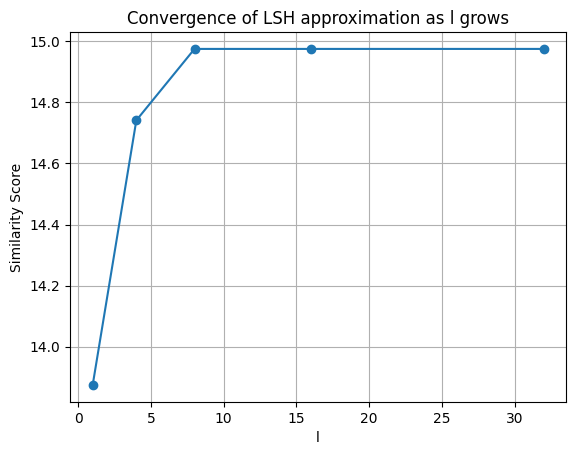

Best l = 8 → doc #19


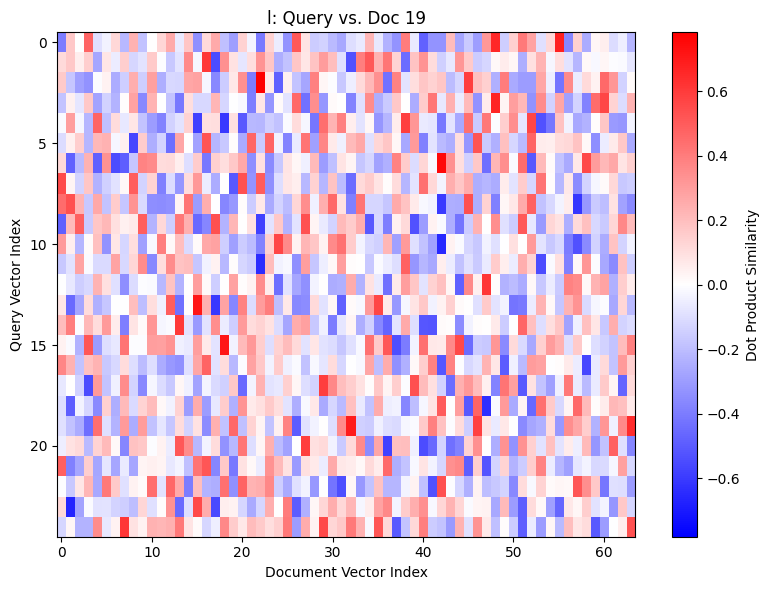

simple_approximate_best took 0.2179 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.2403 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.2433 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.2579 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.2622 sec, 375 vector comparisons (approx)

Finished experiment: k


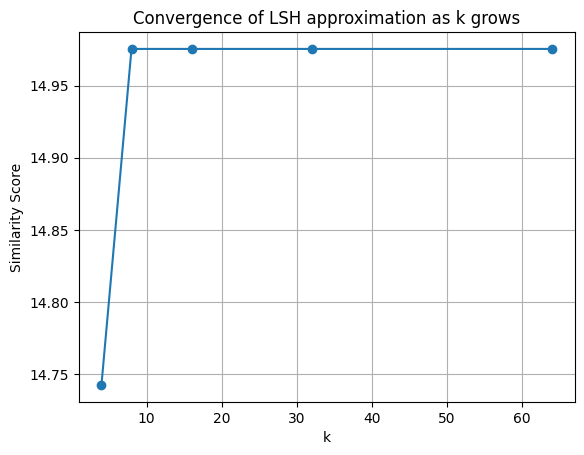

Best k = 8 → doc #19


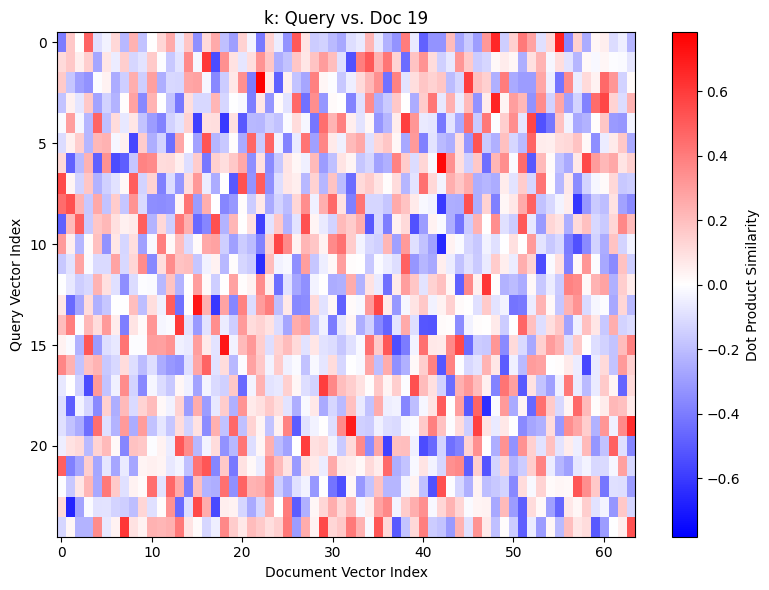

simple_approximate_best took 0.2491 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.2503 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.2563 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.3859 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.6455 sec, 375 vector comparisons (approx)

Finished experiment: km


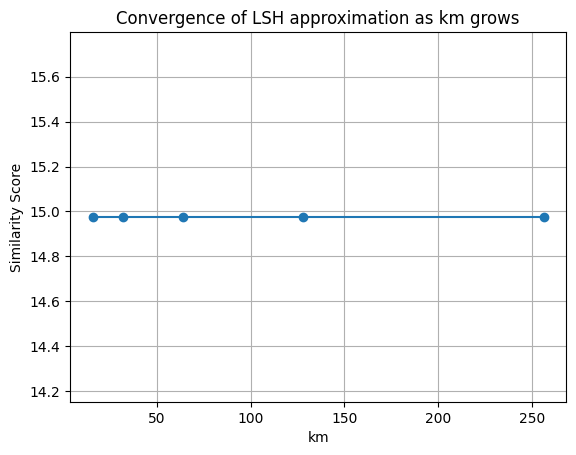

Best km = 16 → doc #19


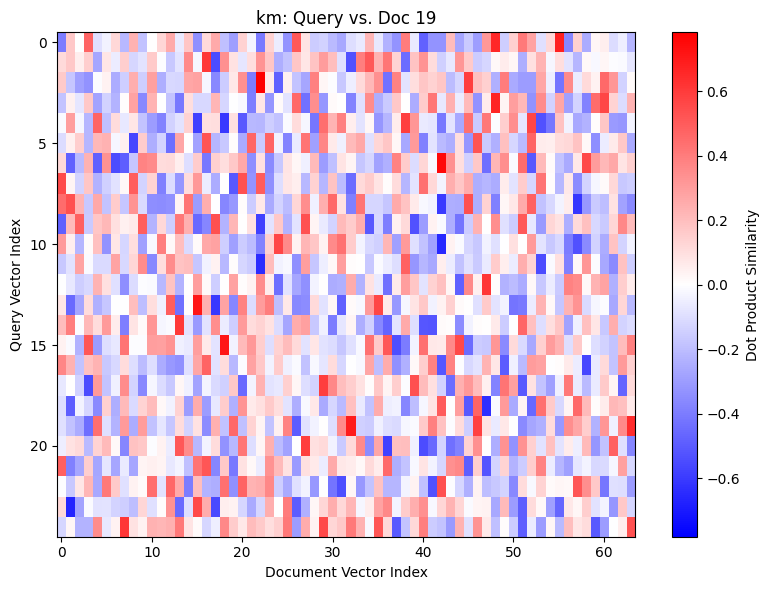

simple_approximate_best took 0.2467 sec, 25 vector comparisons (approx)

simple_approximate_best took 0.2547 sec, 100 vector comparisons (approx)

simple_approximate_best took 0.2551 sec, 200 vector comparisons (approx)

simple_approximate_best took 0.2555 sec, 400 vector comparisons (approx)

simple_approximate_best took 0.2613 sec, 800 vector comparisons (approx)

Finished experiment: a


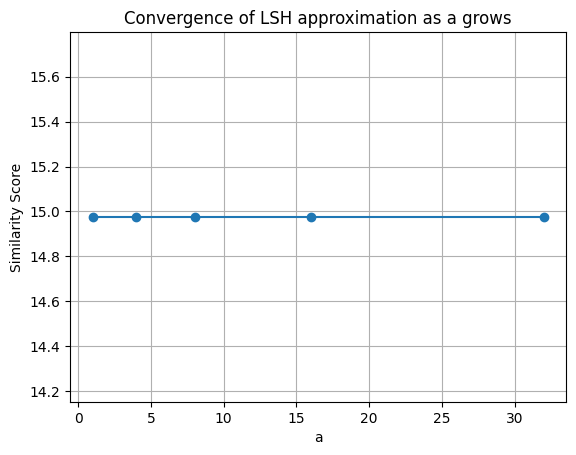

Best a = 1 → doc #19


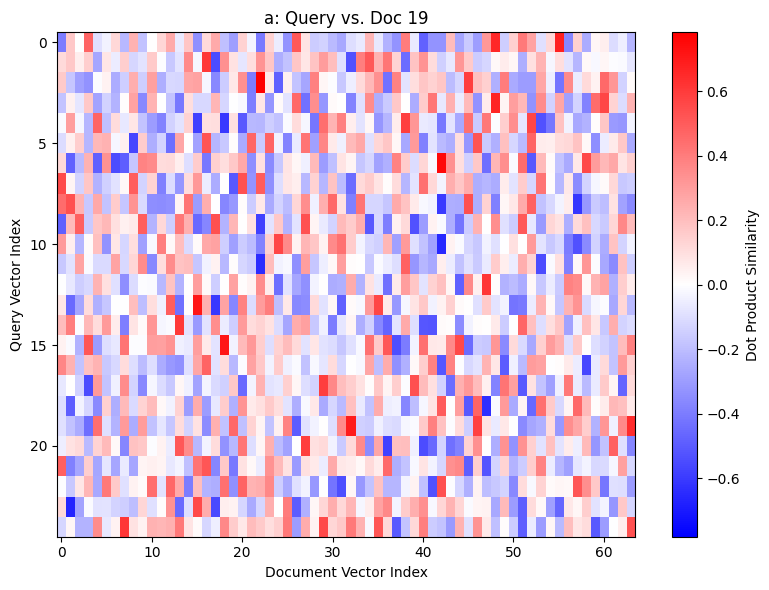

In [3]:
# Evaluate single-doc
results = {}
for var, vals in experiments.items():
    sims, docs = experiment(var, vals, defaults, build_simple_lsh, simple_approximate_best)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    
    # Pick the best result and visualize
    best_index = int(np.argmax(sims))
    best_doc_index = docs[best_index]
    print(f"Best {var} = {vals[best_index]} → doc #{best_doc_index}")
    plot_similarity_heatmap(queries, vectors[best_doc_index],
                            title=f"{var}: Query vs. Doc {best_doc_index}")


In [ ]:

# Evaluate multi-doc
results = {var: experiment(var, vals, defaults, build_multidoc_lsh, multidoc_approximate_best) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'][0],  'number of trees (l)')
plot(experiments['k'],  results['k'][0],  'pivots per node (k)')
plot(experiments['km'], results['km'][0], 'tree depth (km)')
plot(experiments['a'],  results['a'][0],  'neighbours retrieved (a)')


multidoc_approximate_best took 0.0358 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.0571 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.0857 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.1377 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.4446 sec, 375 vector comparisons (approx)

Finished experiment: l
multidoc_approximate_best took 0.1696 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.0970 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.0934 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.0955 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.1080 sec, 375 vector comparisons (approx)

Finished experiment: k
multidoc_approximate_best took 0.0900 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.0992 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.0950 sec,